In [1]:
import save_utils
from config import DATA_FOLDER, FIGURES_FOLDER

import xarray as xr
import numpy as np

import itertools as itr
import os

/home/csquires/projects/orderdag-bounds/venv/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/csquires/projects/orderdag-bounds/venv/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [3]:
def get_dags_folder(p, s):
    return os.path.join(DATA_FOLDER, 's=%s/p=%s' % (s, p))

In [24]:
node_sizes = [3, 5] + list(range(10, 111, 20))
node_size_labels = ['', ''] + list(range(10, 111, 20))
ndags = 2000
sparsities = [.1, .2, .5, .7]
num_interventions = [0, 1, 2]
excluded = [[(.7, 130), (.7, 150)]]

In [5]:
colors = sns.color_palette()
linestyles = ['-', '--', 'dotted']

num_interventions_linestyles = list(zip(num_interventions, linestyles))
sparsity_colors = list(zip(sparsities, colors))

sparsity_labels = [
    mpatches.Patch(color=color, label=r'$\rho$ = %s' % s)
    for s, color in sparsity_colors
]
intervention_labels = [
    mlines.Line2D([0], [0], linestyle=linestyle, color='k', label='r = %s' % k)
    for k, linestyle in num_interventions_linestyles
]
all_handles = list(itr.chain.from_iterable(itr.zip_longest(sparsity_labels, intervention_labels, fillvalue=mlines.Line2D([0], [0], alpha=0))) )

### Create data arrays for number of unoriented edges and MEC sizes

In [6]:
num_unoriented = xr.DataArray(
    np.zeros([len(sparsities), len(node_sizes), ndags, len(num_interventions)]),
    dims=['sparsity', 'nnodes', 'dag', 'num_interventions'], 
    coords={
        'sparsity': sparsities, 
        'nnodes': node_sizes, 
        'dag': list(range(ndags)),
        'num_interventions': num_interventions
    }
)
mec_sizes = num_unoriented.copy()
num_ivs_to_orient = xr.DataArray(
    np.zeros([len(sparsities), len(node_sizes), ndags]),
    dims=['sparsity', 'nnodes', 'dag'],
    coords={
        'sparsity': sparsities,
        'nnodes': node_sizes,
        'dag': list(range(ndags))
    }
)

In [7]:
for s, p, k in itr.product(sparsities, node_sizes, num_interventions):
    if (s, p) not in excluded:
        fn = os.path.join(get_dags_folder(p, s), 'k=%s_num_unoriented.txt' % k)
        num_unoriented.loc[dict(sparsity=s, nnodes=p, num_interventions=k)] = save_utils.load_list(fn) if os.path.exists(fn) else None

        fn = os.path.join(get_dags_folder(p, s), 'k=%s_mec_sizes.txt' % k)
        mec_sizes.loc[dict(sparsity=s, nnodes=p, num_interventions=k)] = save_utils.load_list(fn) if os.path.exists(fn) else None
for s, p in itr.product(sparsities, node_sizes):
    if (s, p) not in excluded:
        fn = os.path.join(get_dags_folder(p, s), 'num_ivs_to_orient.txt')
        num_ivs_to_orient.loc[dict(sparsity=s, nnodes=p)] = save_utils.load_list(fn) if os.path.exists(fn) else None

### Plot average number of unoriented edges and P(isuPDAG)

In [8]:
avg_num_unoriented = num_unoriented.mean(dim='dag')
std_num_unoriented = num_unoriented.std(dim='dag')
percent_updag = (num_unoriented==0).sum(dim='dag')/ndags
# percent_updag.loc[dict(sparsity=.7, nnodes=150)] = None

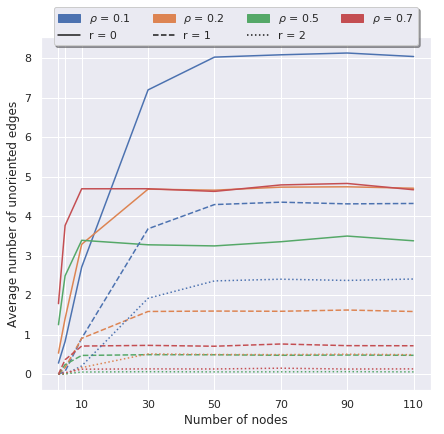

In [25]:
plt.figure(figsize=(7, 6.5))
for (k, linestyle), (s, color) in itr.product(num_interventions_linestyles, sparsity_colors):
    
    plt.plot(
        node_sizes, 
        avg_num_unoriented.sel(sparsity=s, num_interventions=k), 
        linestyle=linestyle, 
        color=color,
        label='s=%s' % s
    )
plt.xticks(node_sizes, node_size_labels)
plt.xlabel('Number of nodes')
plt.ylabel('Average number of unoriented edges')
plt.legend(handles=all_handles, ncol=4, loc='upper center', bbox_to_anchor=(.5, 1.1), shadow=True);
plt.savefig(os.path.join(FIGURES_FOLDER, 'unoriented_edges.png'))

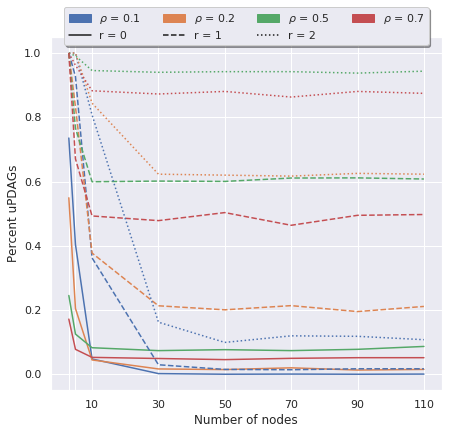

In [26]:
plt.figure(figsize=(7, 6.5))
for (k, linestyle), (s, color) in itr.product(num_interventions_linestyles, sparsity_colors):
    plt.plot(
        node_sizes, 
        percent_updag.sel(sparsity=s, num_interventions=k), 
        linestyle=linestyle, 
        color=color,
        label='s=%s' % s
    )
plt.xticks(node_sizes, node_size_labels)
plt.xlabel('Number of nodes')
plt.xlabel('Number of nodes')
plt.ylabel('Percent uPDAGs')
plt.legend(handles=all_handles, ncol=4, loc='upper center', bbox_to_anchor=(.5, 1.1), shadow=True);plt.savefig(os.path.join(FIGURES_FOLDER, 'percent_updags.png'))

### Plot MEC sizes and log mec sizes

In [11]:
avg_mec_sizes = mec_sizes.mean(dim='dag')
avg_log_mec_sizes = np.log(mec_sizes).mean(dim='dag')

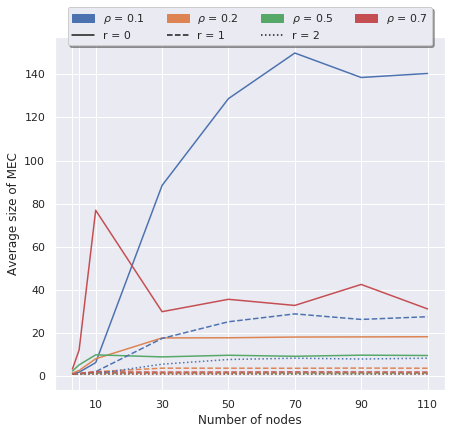

In [27]:
plt.figure(figsize=(7, 6.5))
for (k, linestyle), (s, color) in itr.product(num_interventions_linestyles, sparsity_colors):
    plt.plot(
        node_sizes, 
        avg_mec_sizes.sel(sparsity=s, num_interventions=k), 
        color=color,
        linestyle=linestyle,
        label='s=%s' % s
    )
plt.xticks(node_sizes, node_size_labels)
plt.xlabel('Number of nodes')
plt.xlabel('Number of nodes')
plt.ylabel('Average size of MEC')
plt.legend(handles=all_handles, ncol=4, loc='upper center', bbox_to_anchor=(.5, 1.1), shadow=True);
plt.savefig(os.path.join(FIGURES_FOLDER, 'mec_sizes.png'))

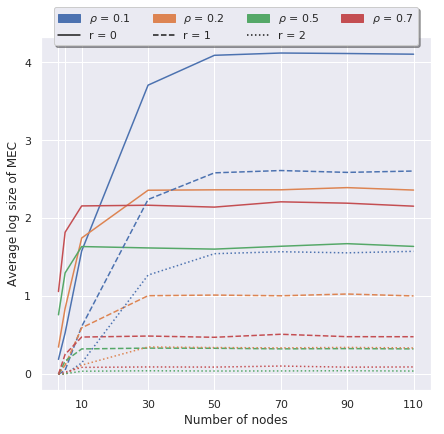

In [28]:
plt.figure(figsize=(7, 6.5))
for (k, linestyle), (s, color) in itr.product(num_interventions_linestyles, sparsity_colors):
    plt.plot(
        node_sizes, 
        avg_log_mec_sizes.sel(sparsity=s, num_interventions=k), 
        color=color,
        linestyle=linestyle,
        label='s=%s' % s
    )
plt.xticks(node_sizes, node_size_labels)
plt.xlabel('Number of nodes')
plt.xlabel('Number of nodes')
plt.ylabel('Average log size of MEC')
plt.legend(handles=all_handles, ncol=4, loc='upper center', bbox_to_anchor=(.5, 1.1), shadow=True);
plt.savefig(os.path.join(FIGURES_FOLDER, 'log_mec_sizes.png'))

### Plot number interventions needed to fully orient

In [14]:
avg_num_ivs_to_orient = num_ivs_to_orient.mean(dim='dag')

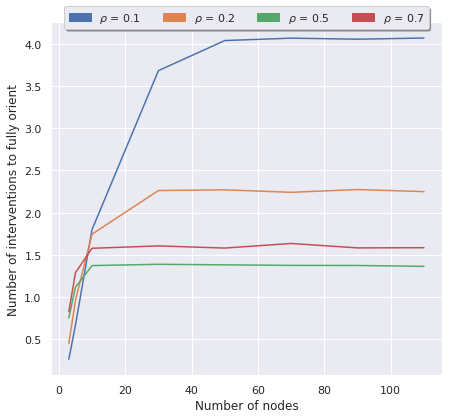

In [15]:
plt.figure(figsize=(7, 6.5))
for s, color in sparsity_colors:
    plt.plot(
        node_sizes,
        avg_num_ivs_to_orient.sel(sparsity=s),
        color=color
    )
    
plt.xlabel('Number of nodes')
plt.ylabel('Number of interventions to fully orient')
plt.legend(handles=sparsity_labels, ncol=4, loc='upper center', bbox_to_anchor=(.5, 1.06), shadow=True);
plt.savefig(os.path.join(FIGURES_FOLDER, 'fully_orienting_interventions.png'))

In [16]:
!tar -czf figures.tar.gz figures